## Tutorial 02: velocity calculation on pancreas dataset

**In tutorial 01 we thoroughly discussed the processing of the pancreas endocrinogenesis datasets. In this tutorial we will continue the $\kappa$-velo pipeline by focusing on the calculation of the velocity. More precisely, we will start of with the recovery of the reaction rate parameters for every single gene. Afterwards, we scale the parameters, so the timescales of the genes match. Lastly, we use the parameters to calculate the velocity for each cell.**

*Initiation data: Tuesday 23.05.2022*\
*Lastest update: Sunday 29.05.2022*\
*Author: Valérie Marot-Lassauzaie (valerie.marot-lassauzaie@mdc-berlin.de)*

In [1]:
### load libraries

# standard libraries
import numpy as np
np.random.seed(0)

# single-cell libraries
import scvelo as scv
import anndata as ad

# plotting libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams # for changing the parameters of the scVelo figures

# dimension reductions
from sklearn.decomposition import PCA #for creating PCAs
from sklearn.preprocessing import StandardScaler #for creating PCAs

# import our own functions
%cd ..
from scripts.processing import *
from scripts.kappavelo import *
from scripts.visualisation import *

/Users/vmarotl/Documents/rna_velocity/cell-state-velocities


In [2]:
### set arguments for plotting
kwargs = {"s":25, "ncols":4, "fontsize":20, 'figsize':(6,3.5),
          "xlabel":"", "ylabel":"", "color":"clusters", "wspace":0.25, "hspace":0.4}
rcParams["axes.grid"] = False
rcParams["axes.spines.right"] = False
rcParams["axes.spines.top"] = False

### Load original dataset

**About the dataset**\
In this tutorial we are using the single-cell dataset of pancreas differentiation published by Bastidas-Ponce and colleagues in 2019 (https://doi.org/10.1242/dev.173849). You can find more information about the dataset in tutorial 01. 

In [3]:
### load pancreas dataset
dataset_path = "./datasets/pancreas/pancreas.h5ad"
adata = ad.read_h5ad(dataset_path)

### Processing the dataset

Here, we will process the dataset in preparation for the velocity calculations. For a detailed description of all of the processing steps head over to tutorial 01. All the following steps are exactly the same with one exception. Before processing we convert the matrices in the Anndata object from sparse to dense. This step is only needed due to the saving format of this object (saving a matrix as sparse takes less space, but for our calculations we need a dense matrix). \*This step is very likely not needed for your own data if you saved it differently.

The steps that we will execute are:
1. convert matrix from sparse to dense\*
2. select HVGS
3. subset for genes with high U and S counts
4. normalise unspliced and spliced counts
5. impute counts

In [4]:
### 1. convert matrices from sparse to dense
print("Converting matrices to dense.")
adata.X = adata.X.todense()
adata.layers['spliced'] = adata.layers['spliced'].todense()
adata.layers['unspliced'] = adata.layers['unspliced'].todense()

### 2. select HVGs
hvgs = get_hvgs(adata, no_of_hvgs=5000, theta=100, layer='spliced')
print("Subsetting to top 5000 highly-variable genes.")
adata = adata[:, hvgs]

### 3. subset for genes that have high enough U and S counts
minlim = 3
us_genes = get_high_us_genes(adata, minlim_u=minlim, minlim_s=minlim)
print("Subsetting to " + str(len(us_genes)) + " genes with sufficient S and U counts.")
adata = adata[:,us_genes]

### 4. L1 normalise unspliced and spliced together
print("Normalising counts.")
normalise_layers(adata, mode='combined', norm='L1')

### 5. imputation
print("Imputing counts.")
impute_counts(adata, n_neighbours = 30, layer_NN = 'spliced', n_pcs = 15)

Converting matrices to dense.
Subsetting to top 5000 highly-variable genes.
Subsetting to 716 genes with sufficient S and U counts.
Normalising counts.
Imputing counts.


Let's have a quick look at the adata object to see if the processing was succesful.  

In [5]:
adata

AnnData object with n_obs × n_vars = 3696 × 716
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'

In [6]:
### select genes of interest
test_genes = ["Abcc8", "Sulf2", "Cpe", "Rap1gap2", "Gcg", "Gng12", "Adk","Gnao1"]

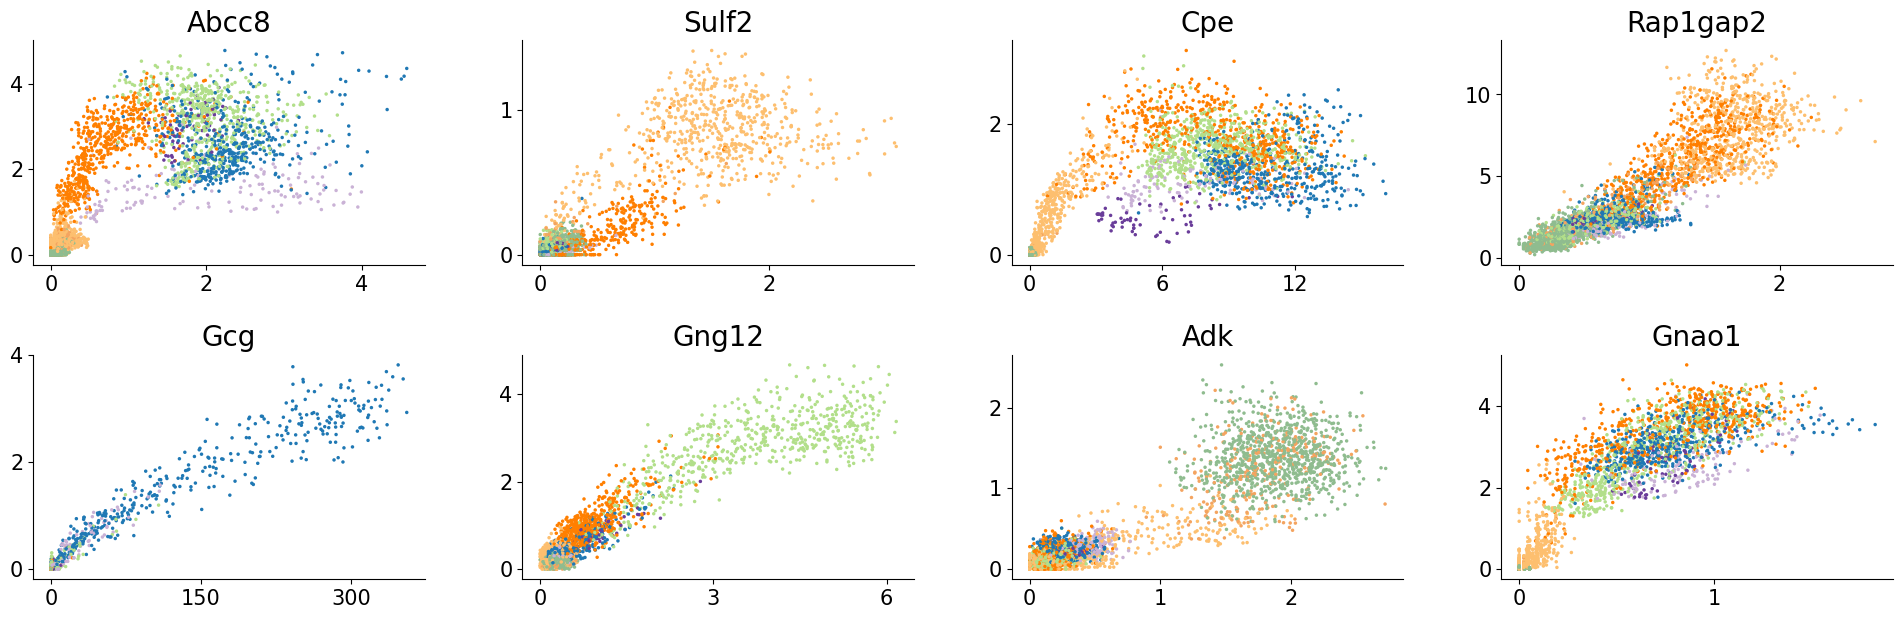

In [7]:
### plot genes of interest after processing
scv.pl.scatter(adata, test_genes, **kwargs)

### Recover reaction rate parameters

After processing, it is time to recover the reaction rate parameters for each gene. The $\kappa$-velo workflow contains 3 steps to recover the reaction rata parameters:

1. gene-wise inference of $\alpha$, $\beta$ and $\gamma$
2. remove low-likelihood genes
3. calculate scaling factor $\kappa$ per gene
4. calculate high-dimensional velocities


**Gene-wise inference of the parameters by scVelo**\
After the processing pipeline we ended up with a matrix with 3696 cells and 716 genes. For each gene we now want to estimate the reaction rate parameters $(\alpha, \beta, \gamma)$ based on the distribution of unspliced and spliced counts. We use scVelo to fit these parameters for all our 716 genes using scVelo's function `recover_dynamics`. 

In [8]:
### recover dynamics for all genes
scv.tl.recover_dynamics(adata, n_jobs=8, fit_connected_states=True, max_iter=100)

# refit 
refit = adata.var.index[np.where(np.isnan(adata.var.fit_likelihood))[0]]
scv.tl.recover_dynamics(adata, refit, n_jobs=8, fit_connected_states=True, max_iter=100)

recovering dynamics (using 8/8 cores)


  0%|          | 0/528 [00:00<?, ?gene/s]

    finished (0:01:31) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
recovering dynamics (using 8/8 cores)


  0%|          | 0/188 [00:00<?, ?gene/s]

    finished (0:00:29) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


**Plotting the recovered parameters**\
We can use the scVelo's fitted parameter to find the phase portrait of each gene. A *phase portrait* is the theoretical trajectory described by the parameters. You can compare it with linear function $y=ax+b$. If you recovered parameters $a$ and $b$, you can draw a line representing the function in a xy-graph. In a phase portrait parameters $\alpha, \beta, \gamma$ allow us to draw a function in a us-graph (unspliced-spliced). 

Now let's have a look at how the *phase portrait* of our genes of interest look.

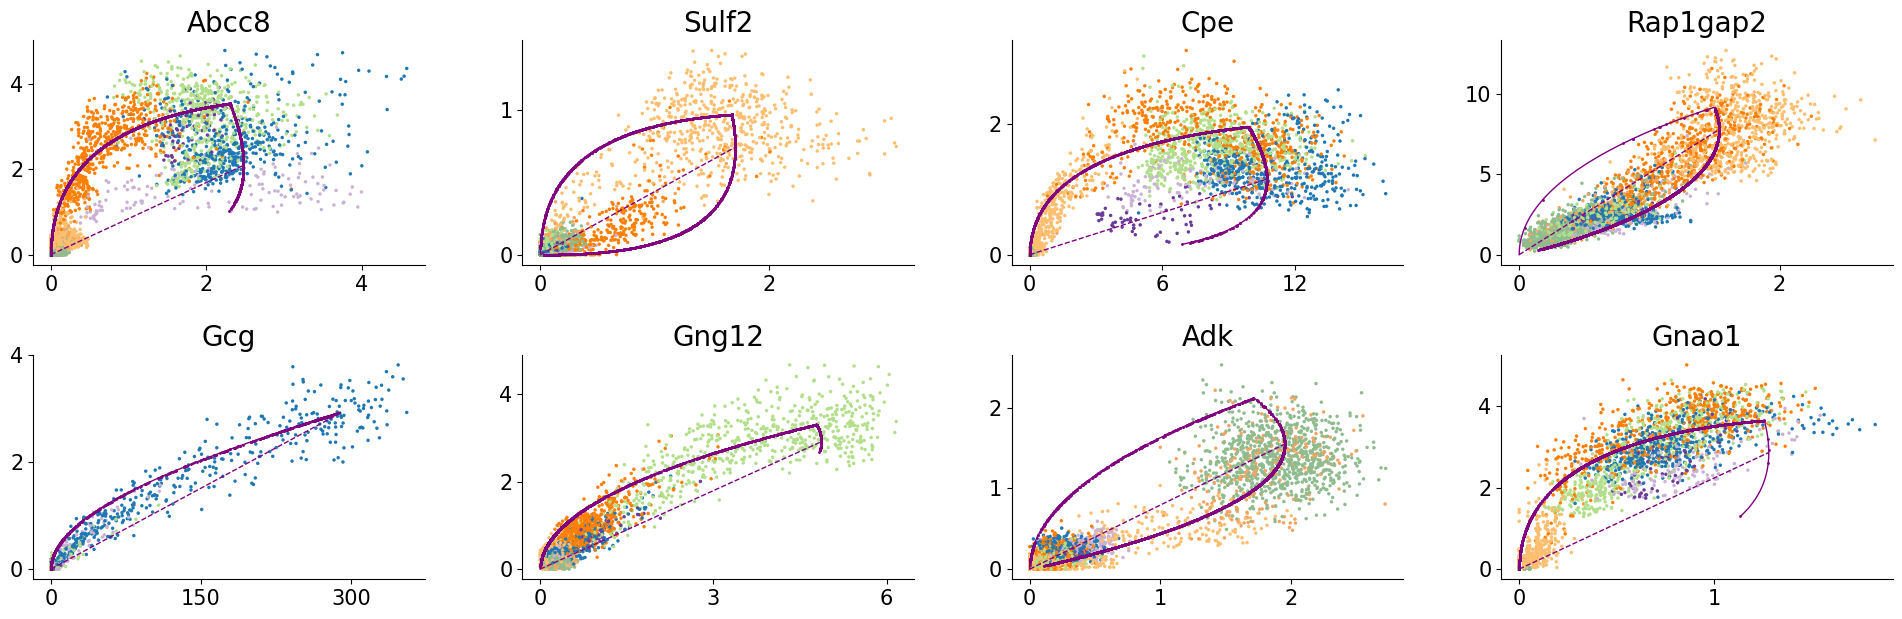

In [9]:
### plot genes of interest after recovering parameters
scv.pl.scatter(adata, test_genes, **kwargs)

**Likelihood score**\
As you can see for gene *Rab3c*, not all genes are well decribed by the phase portrait of the fitted parameters. This can have many different reasons:
- the measurements are too noisy
- the transient state is too short for our measurements, and we only measure the steady-states (bursting gene)
- a gene is described by multiple set of reaction rates parameters. This can happen when we have very distinct cell populations in the samples.
- scVelo does not fit the observed values correctly

Because of this, we need to check whether the phase portrait fits to our gene, and potentially filter badly fitted gene. Luckily, scVelo returns a likelihood score between 0 and 1 for each fit, which describes how well the recovered phase portrait describes the actual datapoints. The score is saved under `adata.var.fit_likelihood`. Next, we will have a look at the best and worst fitted genes (based on scVelo's likelihood score). 

In [10]:
### get all genes sorted by likelihood
likelihood_genes = adata.var['fit_likelihood'].sort_values(ascending=False)

In [11]:
### remove genes where scVelo failed to recover any dynamics
likelihood_genes = likelihood_genes.dropna()

Top 8 high-likelihood genes:


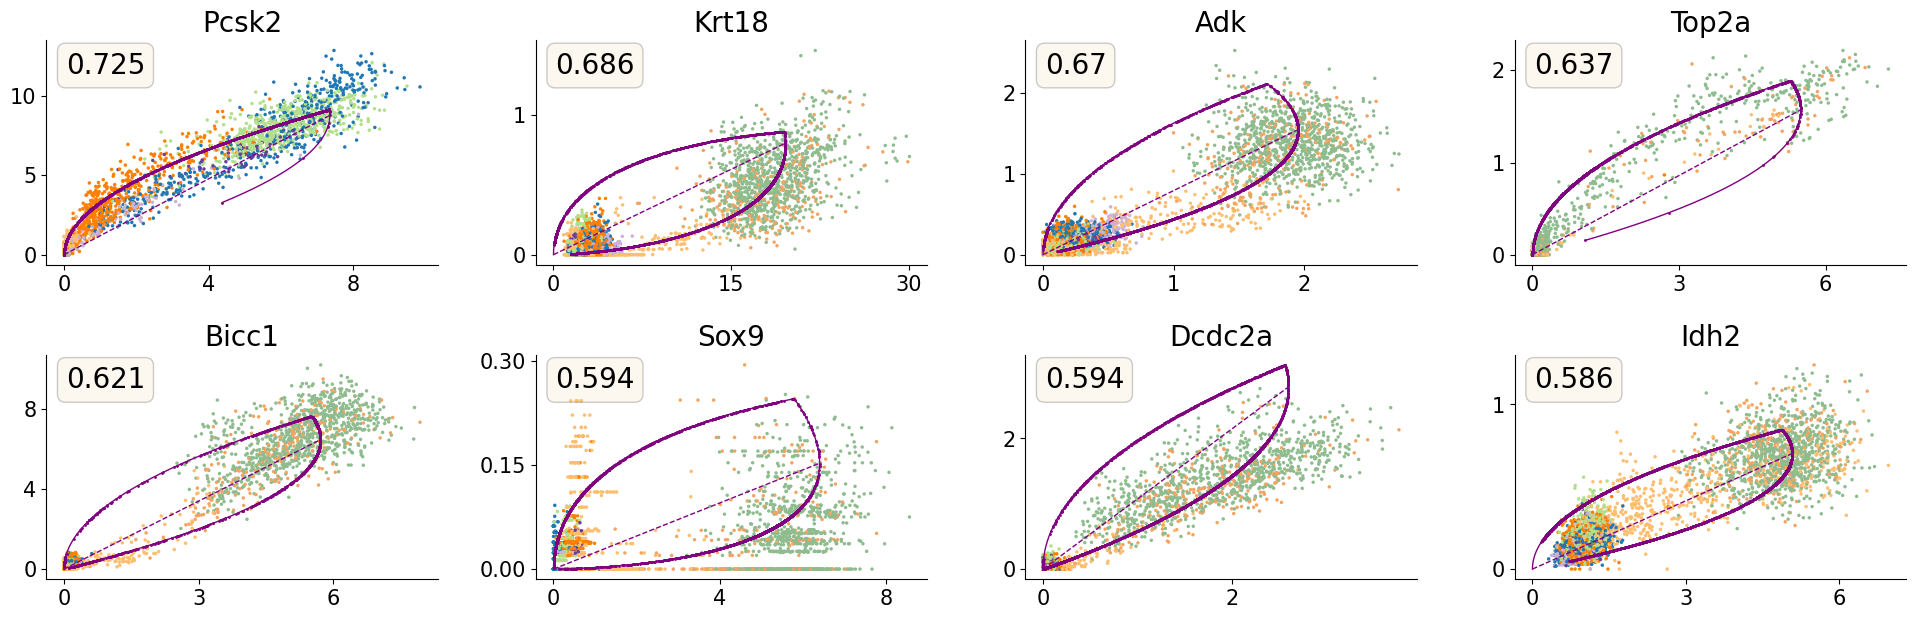

In [12]:
### plot top likelihood genes
print("Top 8 high-likelihood genes:")
scv.pl.scatter(adata, likelihood_genes[:8].index, **kwargs, add_text=np.round(likelihood_genes[:8].values, 3))

Last 8 low-likelihood genes:


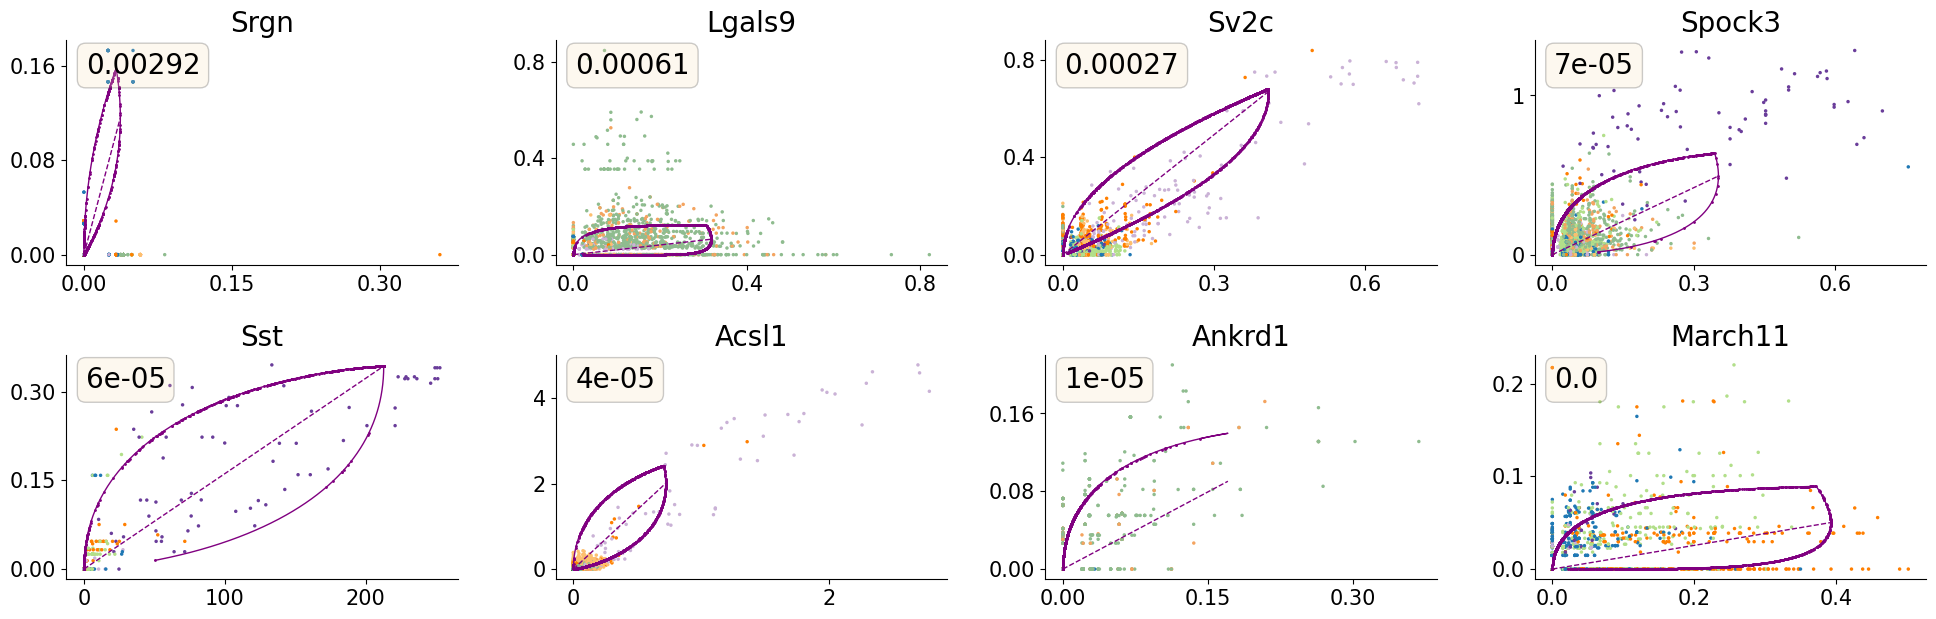

In [13]:
print("Last 8 low-likelihood genes:")
scv.pl.scatter(adata, likelihood_genes[-9:-1].index, **kwargs, add_text=np.round(likelihood_genes[-9:-1].values, 5))

Lastly, let's look at the likelihood score that was assigned to our genes of interest.

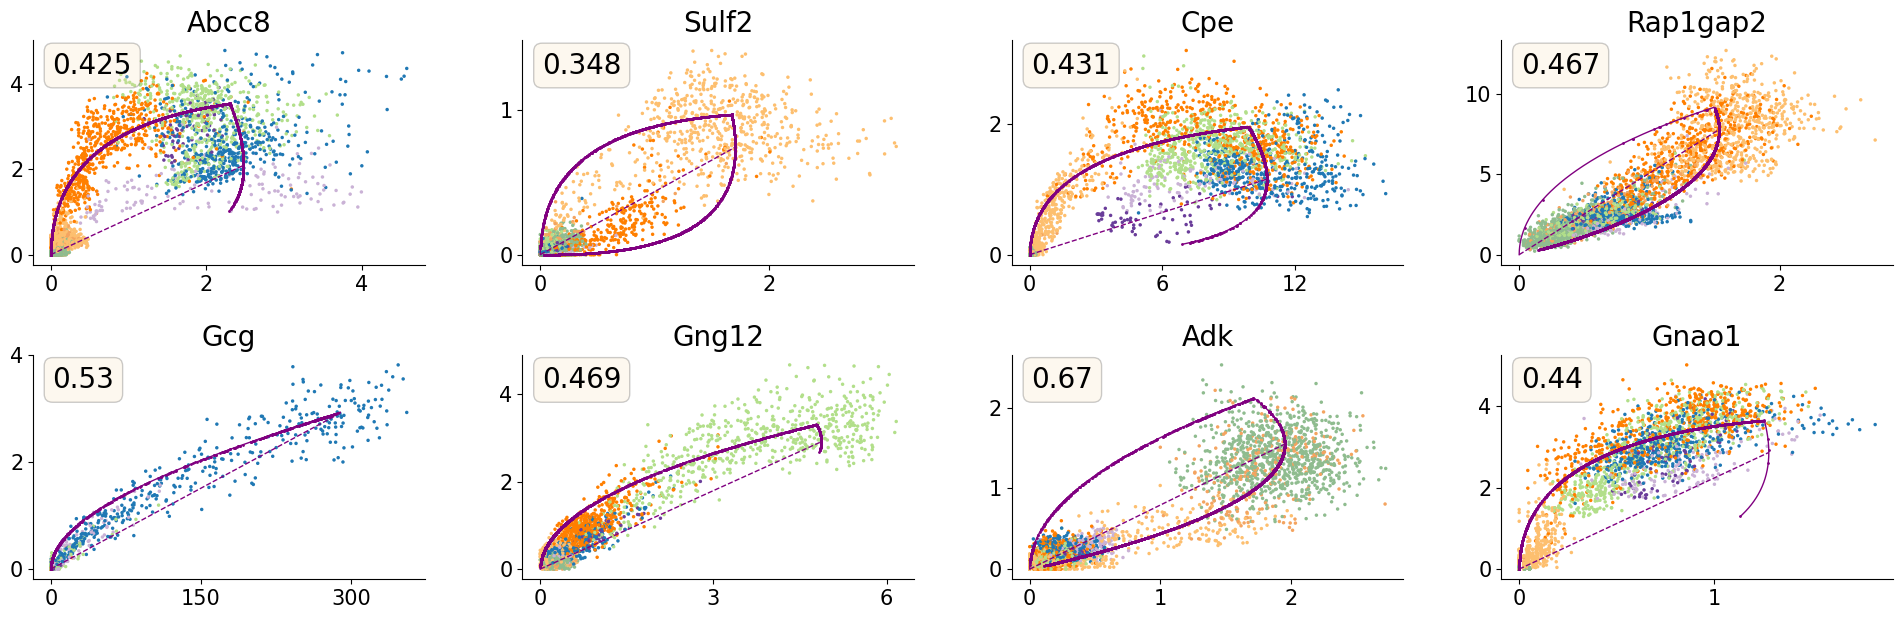

In [14]:
### plot our genes of interest with likelihood score
scv.pl.scatter(adata, test_genes, **kwargs, add_text=np.round(likelihood_genes[test_genes].values, 3))

### Remove low-likelihood genes

In the figures above we can see that the genes with the lowest likelihood scores (low-likelihood genes) do not have clear dynamics. The recovered parameters and velocities for these genes are most likely incorrect. Therefore we remove genes with low likelihood scores before continuing with our velocity calculations.

Before filtering out the low-likehood genes, let's have a look at the distribution of likelihoods.

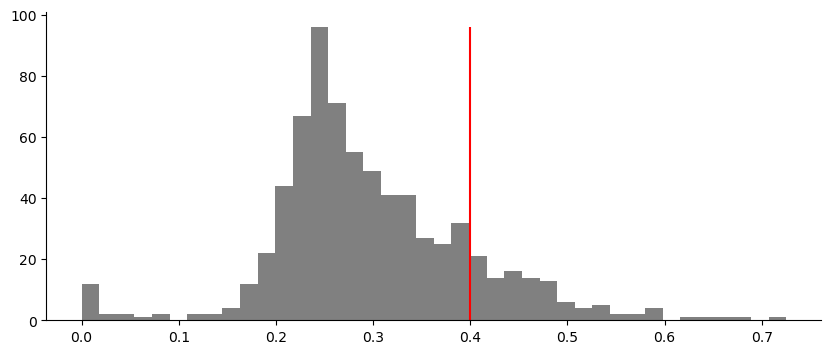

In [15]:
fig = plt.figure(figsize=(10, 4))
y = plt.hist(adata.var['fit_likelihood'], bins=40, color="grey")
plt.vlines(.4, 0, np.max(y[0]), color="red")
plt.show()

Now, we select only the genes that have a likelihood score above 0.4. This leaves us with a total of 103 genes that are included in our velocity calculations. If you are working with your own dataset we highly recommend to have your own look at which cutoff works best for your dataset. 

In [16]:
### get all genes sorted by likelihood
likelihood_genes = adata.var['fit_likelihood'].sort_values(ascending=False)

### remove genes with no recovered dynamics
likelihood_genes = likelihood_genes.dropna()

### select genes with likelihood higher than x
likelihood_genes = likelihood_genes[likelihood_genes > 0.4]

### select only the genes in pandas series
likelihood_genes = likelihood_genes.index.values

print(str(len(likelihood_genes))+" high-likelihood genes kept")

### subset adata for genes with recovered parameters
adata = adata[:, likelihood_genes]

106 high-likelihood genes kept


### Calculate scaling factor $\kappa$ per gene

**Theory behind scaling parameters**\
Because the solutions to the ODE are not unique $(\alpha, \beta, \gamma)$ is a solution and $(\kappa\alpha, \kappa\beta, \kappa\gamma)$ is a solution as well for ANY $\kappa$. 

There are different assumptions that can be made to work around this issue. In our work, we show that $\Delta t$ a measure of true time between two cells can be used to relate the parameters accross genes and solve for the gene-specific $\kappa$. Since we do not have a true measure of $\Delta t$, we propose that cell densities, i.e. number of cells that are captured between two cell states, can be used instead. In snapshot data, the probability of capturing cells in a specific region of the expression space is proportional to the time cells typically spend in that region. Therefore cell density is inversely proportional to the average velocity in any expression region.

Note the scale of recovered $\kappa$ will not be exactly true to time, but can be off by a constant factor related to the chosen $\Delta t$. However, if all components are scaled by the same factor, the direction of the high dimensional vector is still correct.

For a more detailed theoretical explanation we invite you to read 2.1.1-2.1.3 in our Biorxiv preprint. 

**Approach to scaling parameters**\
To scale the parameters that we have calculated for each individual gene, we use function `kappa_velo`. This function will alter `'fit_alpha'`, `'fit_beta'`, `'fit_gamma'`, `'fit_t_'` (the timepoint where the function switches between upregulation and downregulation) in our adata object. Additionally, it will add `'fit_kappa'` with the scaling factor kappa that was calculated for each gene. 

If you are more interested into the details of the algorithms you can find more information in Supplementary note 2 of our preprint. 

In [17]:
### get kappa and scale anndata object
scaled_data = kappa_velo(adata, inplace=False)

Let's have a look at the range of scaled parameters $\alpha, \beta, \gamma$ in three histograms.

In [ ]:
### plot the recovered parameters
fig, axs = plt.subplots(1, 3, figsize=(9,5), frameon=False, sharey=False)

pars = ["alpha", "beta", "gamma"]
for i in range(3):
    rate_par = scaled_data.var["fit_"+pars[i]]/np.median(scaled_data.var["fit_"+pars[i]])
    axs[i].hist(np.log10(rate_par), bins=20, alpha=.6, color="tab:red")
    l = np.max(np.log10(rate_par))
    axs[i].set_xlim((-l, l))
    axs[i].set_title(pars[i])
    axs[i].grid(False)
    axs[i].set_yticks([0, 10, 20])
    axs[i].set_ylabel("Frequency")
    axs[i].set_xlabel("log10" +pars[i])

plt.tight_layout()
plt.show()

Conveniently, after scaling we can get an idea about the "speed" of different genes. We consider genes fast when they have high splicing rates and slow when they have low splicing rates. Let's have a look at a few "fast" and "slow" genes.

In [ ]:
### get fastest genes
idx = np.argsort(-scaled_data.var["fit_beta"])[:8].tolist()

In [ ]:
### plot 8 fastest genes
print("Top 8 fastest genes:")
scv.pl.scatter(adata, adata.var_names[idx],  **kwargs)

In [ ]:
### get slowest genes
idx=np.argsort(scaled_data.var["fit_beta"])[:8].tolist() # 5 slowest genes

In [ ]:
### plot slowest genes
print("Top 8 slowest genes:")
scv.pl.scatter(adata, adata.var_names[idx],  **kwargs)

### Calculate velocities

Lastly, given the scaled reaction rates parameters we can recover the high dimensional velocity vector. The velocities are defined as:

$\frac{ds}{dt}=\kappa\beta U - \kappa\gamma S$

We will use function `get_velocity` to calculate the velocities for every cell per gene. This function stores the resulting matrix in the adata under `adata.layers["velocity"]`. 

In [ ]:
### calculate velocity
get_velocity(scaled_data, use_raw=False, normalise="L1")

In [ ]:
scaled_data

The last step in this tutorial is to save the `scaled_data` object. In the next tutorial we will explain how to plot the calculated velocities. However, because the recovery of the parameters and the scaling step are slightly time consuming we save our object so we don't have to run those steps again. 

In [ ]:
### save Anndata object
name_file = "pancreas_velocities_calculated.h5ad"
adata_path  = "datasets/pancreas/" + name_file
scaled_data.write_h5ad(adata_path)